In [53]:
from langgraph.graph import StateGraph, START, END
from langchain_groq import ChatGroq
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.checkpoint.memory import MemorySaver  # here implementing presistence for storing state in every loop using checkpointer


In [54]:
from langgraph.graph.message import add_messages  # this add_message help as a reduce function to store converstation history

# first define the state of graph
class ChatState(TypedDict):

    messages: Annotated[list[BaseMessage], add_messages]
    # this list[BaseMessage] can take all message type (HumanMessage, AIMessage, ToolMessage,SystemMessage) as all MessageType inherit from BaseMessage class

In [57]:
llm = ChatGroq(model = "Llama3-8b-8192")


def chat_node(state: ChatState):

    # take user query from state
    messages = state['messages'] 
    
    # send to llm
    response = llm.invoke(messages)
    
    # response store inside defined state 'messages'
    return {'messages':[response]}

In [59]:
checkpointer = MemorySaver()  # for persistence

graph = StateGraph(ChatState)

# add node
graph.add_node('chat_node', chat_node)


graph.add_edge(START, 'chat_node')
graph.add_edge('chat_node', END)

workflow = graph.compile(checkpointer=checkpointer)   #when you are compiling you graph then pass checkpointer & that checkpointer type is memorysaver


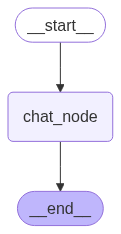

In [58]:
workflow

In [64]:
initial_state = {
    "messages" : [HumanMessage(content='What is the capital of india')]
}

result = workflow.invoke(initial_state)['messages'][-1].content

ValueError: Checkpointer requires one or more of the following 'configurable' keys: thread_id, checkpoint_ns, checkpoint_id

In [48]:
result

'The capital of India is New Delhi.'

In [65]:
thread_id = '1'  #using threads in persistence for storing independent interaction of each user

# for adding continously chatting feature withing chatbot
while True:
    user_message = input('Type here:')
    print('user:', user_message)
    
    if user_message.strip().lower() in ['quit','exit','bye']:
        break

    config = {'configurable': {'thread_id': thread_id}}  # then create a config variable that will consist of dict with key-value pair of thread_id

    response = workflow.invoke({'messages': [HumanMessage(content=user_message)]}, config=config)  #while invoking we'll send config var also

    print('AI:', response['messages'][-1].content)

  

user: hi, my name is kanishka
AI: Hi Kanishka! Nice to meet you! Welcome to our conversation. How's your day going so far?
user: what is my name
AI: I remember! Your name is Kanishka!
user: what is 10 *2
AI: Easy one!

10 * 2 = 20
user: then add 10
AI: Let's add 10 to 20:

20 + 10 = 30
user: quit


In [66]:
workflow.get_state(config=config)  #isse hum puri conversation history ko state mai rak pa rhae hai aur dek skte hai , 

StateSnapshot(values={'messages': [HumanMessage(content='hi, my name is kanishka', additional_kwargs={}, response_metadata={}, id='8c5ee2ed-1f9b-46f7-a485-793851719f7b'), AIMessage(content="Hi Kanishka! Nice to meet you! Welcome to our conversation. How's your day going so far?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 18, 'total_tokens': 42, 'completion_time': 0.028531073, 'prompt_time': 0.003151099, 'queue_time': 0.265723577, 'total_time': 0.031682172}, 'model_name': 'Llama3-8b-8192', 'system_fingerprint': 'fp_c0b3855449', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--8c638377-db79-49e2-93ba-456890e320be-0', usage_metadata={'input_tokens': 18, 'output_tokens': 24, 'total_tokens': 42}), HumanMessage(content='what is my name', additional_kwargs={}, response_metadata={}, id='ccc649b0-6bf7-4245-a720-0159763546bb'), AIMessage(content='I remember! Your name is Kanishka!', additional_kwargs={}, re